In [2]:
# Define input and output data
#!pip install torch torchvision torchaudio
#!pip uninstall matplotlib -y
#import matplotlib
#!pip install openpyxl

In [3]:
import torch
torch.manual_seed(0)  # For reproducibility
#!conda --version
#!pip install flaml[automl]
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sklearn
from sklearn.ensemble import RandomForestRegressor as RF
import pickle
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
import xarray as xr

### 数据读取和预处理

In [4]:
# The data catalogue is stored as a CSV file. Here we read it with pandas.
data_path1 = 'D:/A_sem2/ERP/Simulation/lhs_exps.csv' # Change this to the path of the data file on your system
data_path2 = 'D:/A_sem2/ERP/Code/TSA_max_min_mean.xlsx' # Change this to the path of the data file on your system

# Load the data
df1 = pd.read_csv(data_path1, index_col=0, parse_dates=True)
df1 = df1.drop(columns=['ALB_ROOF_DIF', 'ALB_IMPROAD_DIF', 'ALB_PERROAD_DIF', 'ALB_WALL_DIF'])
# display(df1)
df2 = pd.read_excel(data_path2, parse_dates=True)

# 1. 加载数据
df_input = df1.values  # 输入特征CSV
df_output = df2.iloc[:, 2].values  # 输出特征Excel，只有1列
# print(df_input)
# print(df_output)

# 2. 特征标准化
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(df_input)
scaler_y = StandardScaler()
df_output = df_output.reshape(-1,1)
y_scaled = scaler_y.fit_transform(df_output)

# 3. 转torch张量
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_scaled, dtype=torch.float32)

# 4. 分train/test   (可以进一步用sklearn的train_test_split)
train_size = int(0.8 * len(X_tensor))
X_train, X_test = X_tensor[:train_size], X_tensor[train_size:]
y_train, y_test = y_tensor[:train_size], y_tensor[train_size:]

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# 5. DataLoader
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_968\3915313162.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df1 = pd.read_csv(data_path1, index_col=0, parse_dates=True)


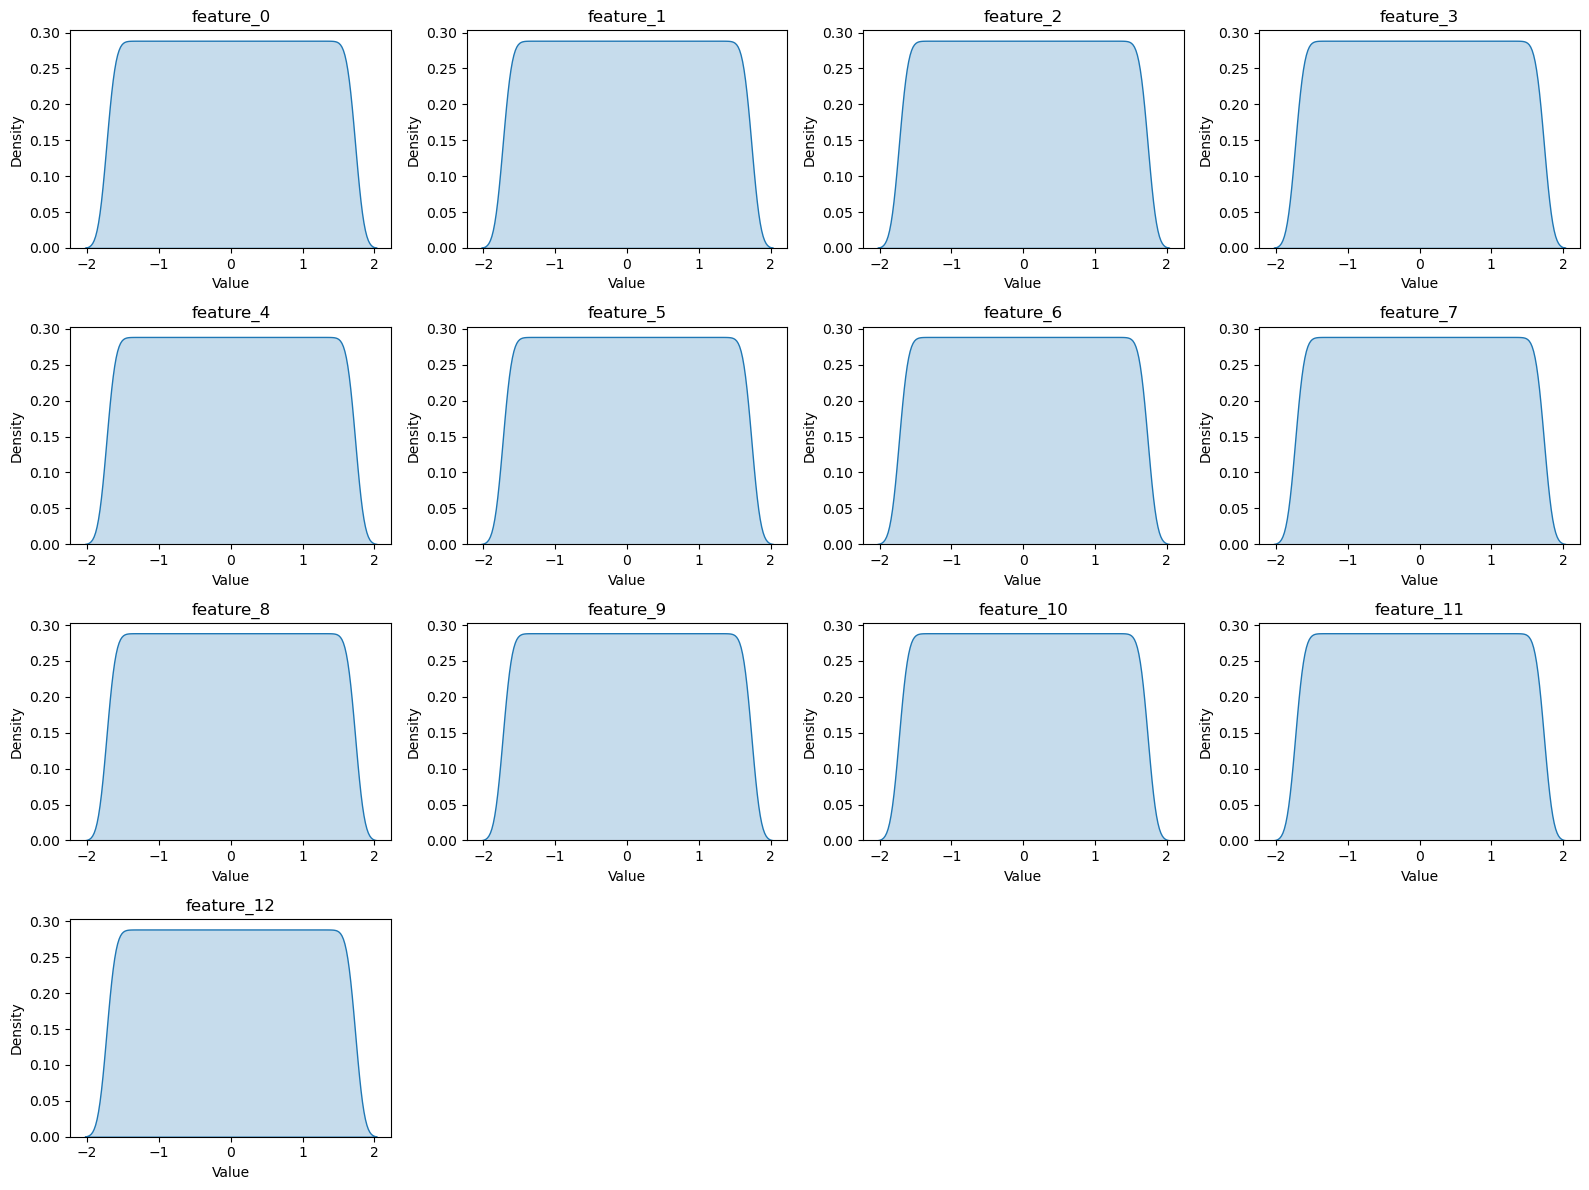

In [5]:
# 1. 转成numpy数组，shape [样本数, 特征数]
X_np = X_tensor.numpy()

num_features = X_np.shape[1]
features_names = [f'feature_{i}' for i in range(num_features)]

# 创建子图，4行4列，容纳所有特征
fig, axes = plt.subplots(4, 4, figsize=(16, 12))
axes = axes.flatten()

for i in range(num_features):
    sns.kdeplot(X_np[:, i], ax=axes[i], fill=True)
    axes[i].set_title(features_names[i])
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Density')

# 隐藏多余子图
for j in range(num_features, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

### 定义MLP模型
nn.Sequential按顺序组合以下层：

nn.Linear(input_dim, 64)：全连接层，将输入维度映射到64个神经元。

nn.ReLU()：激活函数，增加非线性能力。

nn.Linear(64, 32)：第二层全连接，64维映射到32维。

nn.ReLU()：再一次引入ReLU非线性。

nn.Linear(32, 1)：输出层，32维映射到1维，即输出一个标量结果，适合回归。

对nn.Linear(input_dim, 64)的解释：
输入特征（input_dim）数量和**隐层神经元数量（比如64）**没有硬性线性对应关系。
通常隐层神经元要多于输入特征（尤其在特征数量不多时）这样隐层有处理和表达复杂特征的能力。
实际项目中，64、128、32等值都是常见的经验数值起点。

In [6]:
# 定义MLP模型
import torch.nn as nn

class MLPRegressor(nn.Module):# 定义一个MLP模型，继承自nn.Module，PyTorch所有神经网络模块都从这里继承。
    def __init__(self, input_dim):# 初始化方法，接收模型输入特征维度input_dim。
        super().__init__() # 调用父类初始化，保证nn.Module正常工作。
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)   # 输出为1，单输出回归
        )
    def forward(self, x): # 定义网络的前向传播，输入x依次通过上述self.model层处理，得到输出。
        return self.model(x) # 这一步告诉PyTorch 的计算图怎么从输入到输出计算。

input_dim = X_tensor.shape[1] # 特征数，即有多少个input variables
model = MLPRegressor(input_dim)

### 训练模型

In [7]:
# 训练模型
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 60
for epoch in range(num_epochs): # 外层循环遍历所有训练的epoch。
    model.train() # 设置模型为训练模式，比如启用dropout和batchnorm训练行为。
    train_loss = 0.0 # 遍历训练数据加载器的批次，xb是输入批次张量，yb是目标标签批次。
    for xb, yb in train_loader: # 遍历训练数据加载器的批次，xb是输入批次张量，yb是目标标签批次。
        optimizer.zero_grad() # 清空之前的梯度，避免梯度累积。
        output = model(xb) # 前向传播，计算模型预测输出。
        # yb shape: [B, 1] / output: [B, 1]
        loss =  torch.sqrt(criterion(output, yb)) # 计算当前批次的损失（RMSE）。
        loss.backward() # 反向传播，计算梯度。
        optimizer.step() # 根据梯度更新模型参数。
        train_loss += loss.item() * xb.size(0) # 把当前批次的损失乘以批尺寸累加，准备算平均损失
    train_loss /= len(train_loader.dataset) # 除以训练集总样本数，得到全训练集的平均损失。
    print(f"Epoch {epoch+1}/{num_epochs}  Train Loss: {train_loss:.4f}") # 

Epoch 1/60  Train Loss: 0.3298
Epoch 2/60  Train Loss: 0.1494
Epoch 3/60  Train Loss: 0.1274
Epoch 4/60  Train Loss: 0.1120
Epoch 5/60  Train Loss: 0.1042
Epoch 6/60  Train Loss: 0.0988
Epoch 7/60  Train Loss: 0.0936
Epoch 8/60  Train Loss: 0.0912
Epoch 9/60  Train Loss: 0.0881
Epoch 10/60  Train Loss: 0.0868
Epoch 11/60  Train Loss: 0.0848
Epoch 12/60  Train Loss: 0.0838
Epoch 13/60  Train Loss: 0.0814
Epoch 14/60  Train Loss: 0.0823
Epoch 15/60  Train Loss: 0.0818
Epoch 16/60  Train Loss: 0.0808
Epoch 17/60  Train Loss: 0.0792
Epoch 18/60  Train Loss: 0.0794
Epoch 19/60  Train Loss: 0.0785
Epoch 20/60  Train Loss: 0.0785
Epoch 21/60  Train Loss: 0.0774
Epoch 22/60  Train Loss: 0.0775
Epoch 23/60  Train Loss: 0.0774
Epoch 24/60  Train Loss: 0.0783
Epoch 25/60  Train Loss: 0.0760
Epoch 26/60  Train Loss: 0.0749
Epoch 27/60  Train Loss: 0.0748
Epoch 28/60  Train Loss: 0.0739
Epoch 29/60  Train Loss: 0.0738
Epoch 30/60  Train Loss: 0.0753
Epoch 31/60  Train Loss: 0.0747
Epoch 32/60  Trai

In [8]:
# 验证模型
model.eval()
with torch.no_grad():
    total_loss = 0
    for xb, yb in test_loader:
        output = model(xb)
        loss = criterion(output, yb)
        total_loss += loss.item() * xb.size(0)
    avg_loss = total_loss / len(test_loader.dataset)
    # print(f"Test Loss (MSE, 标准化后): {avg_loss:.4f}")

    # 恢复原始量纲预测（举例）
    # train
    y_train_pred_scaled = model(X_train).cpu().numpy()
    y_train_pred_real = scaler_y.inverse_transform(y_train_pred_scaled)
    y_train_real = scaler_y.inverse_transform(y_train.cpu().numpy())
    residuals_train = y_train_real - y_train_pred_real
    print("training rmse:", mean_squared_error(y_true=y_train_real, y_pred=y_train_pred_real, squared=False))
    print("training r2:", r2_score(y_true=y_train_real, y_pred=y_train_pred_real))
    print("training mae:", mean_absolute_error(y_true = y_train_real, y_pred = y_train_pred_real))
    # test
    y_test_pred_scaled = model(X_test).cpu().numpy()
    y_test_pred_real = scaler_y.inverse_transform(y_test_pred_scaled)
    y_test_real = scaler_y.inverse_transform(y_test.cpu().numpy())
    residuals_test = y_test_real - y_test_pred_real
    print(" ")
    print("testing rmse:", mean_squared_error(y_true=y_test_real, y_pred=y_test_pred_real, squared=False))
    print("testing r2:", r2_score(y_true=y_test_real, y_pred=y_test_pred_real))
    print("testing mae:", mean_absolute_error(y_true = y_test_real, y_pred = y_test_pred_real))





training rmse: 0.13132894
training r2: 0.9891090240040591
training mae: 0.031408437
 
testing rmse: 0.10498748
testing r2: 0.9930290756922528
testing mae: 0.031147052


d:\python_Anaconda_install\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
d:\python_Anaconda_install\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [9]:
### 将y_test_real写成nc格式文件

# display(y_test_real.shape)
# ds_test_mlp = xr.Dataset(
#     {
#         "y_pred": (("200000", "1"), y_test_real)
#     },
# )
# ds_test_mlp.to_netcdf("ERP_ds_test_mlp.nc")# ERP_y_pred_grid_mlp.nc
# print("NetCDF 文件保存成功！")



In [10]:
# 保存和加载模型
torch.save(model.state_dict(), "ERP_mlp_regressor_TSAmean.pth")
# 加载：
# model.load_state_dict(torch.load("ERP_mlp_regressor_TSAmean.pth"))

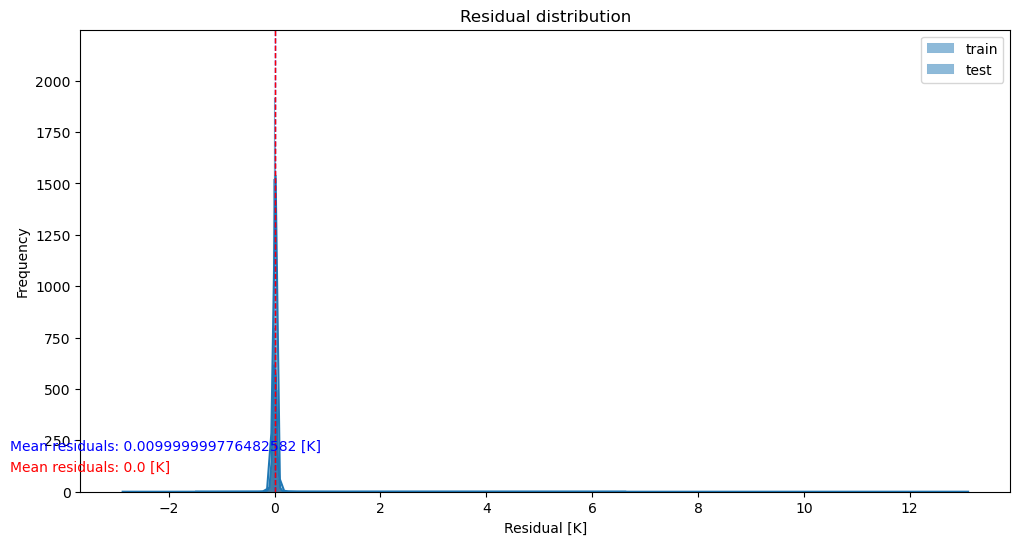

In [11]:
### example plotting

plt.figure(figsize=(12, 6))
sns.histplot(residuals_train, kde=True, color='blue', label='train')# , binwidth = 0.1
sns.histplot(residuals_test, kde=True, color='red', label='test')

mean_train = residuals_train.mean()
mean_test = residuals_test.mean()

plt.axvline(mean_train, color='blue', linestyle='dashed', linewidth=1)
plt.axvline(mean_test, color='red', linestyle='dashed', linewidth=1)

plt.text(-5, 200, f'Mean residuals: {mean_train.round(2)} [K]', rotation=0, color='blue')
plt.text(-5, 100, f'Mean residuals: {mean_test.round(2)} [K]', rotation=0, color='red')

plt.ylabel('Frequency')
plt.xlabel('Residual [K]')
plt.title('Residual distribution')
plt.legend()
plt.show()

100%|██████████| 100/100 [00:10<00:00,  9.87it/s]


shap_values.shape: (100, 13, 1)
X_explain.shape: (100, 13)
len(feature_names): 13
feature_names: ['ALB_ROOF_DIR', 'EM_ROOF', 'ALB_IMPROAD_DIR', 'EM_IMPROAD', 'ALB_PERROAD_DIR', 'EM_PERROAD', 'ALB_WALL_DIR', 'EM_WALL', 'WIND_HGT_CANYON', 'HT_ROOF', 'CANYON_HWR', 'WTLUNIT_ROOF', 'WTROAD_PERV']


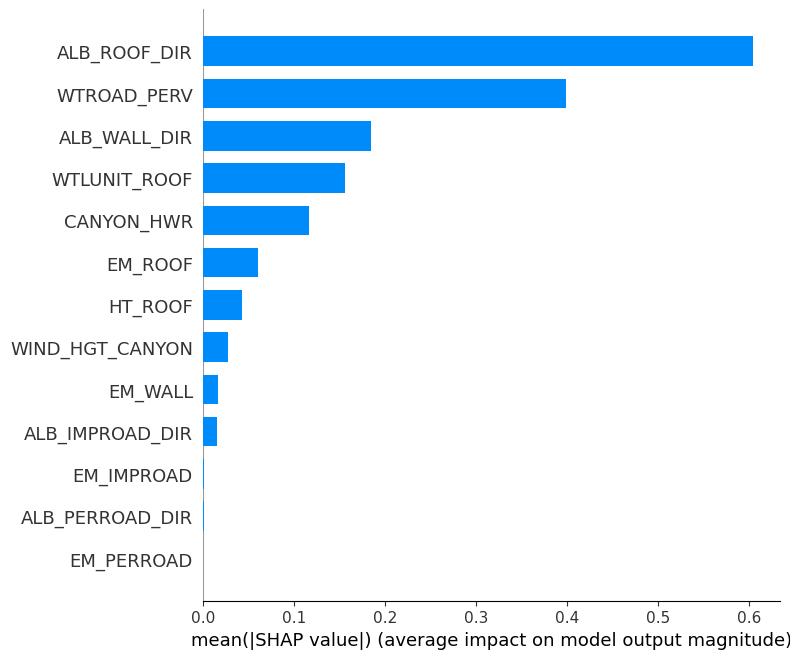

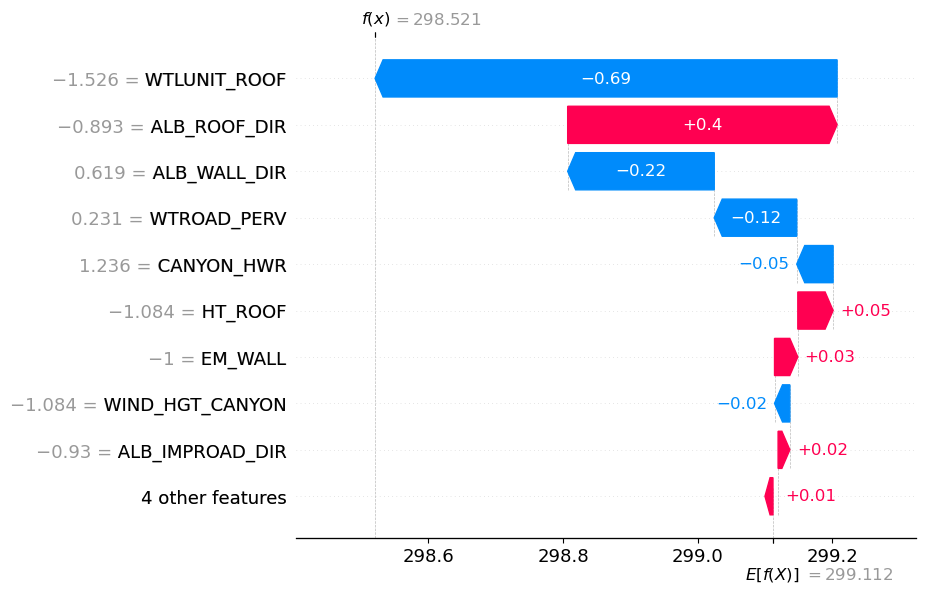

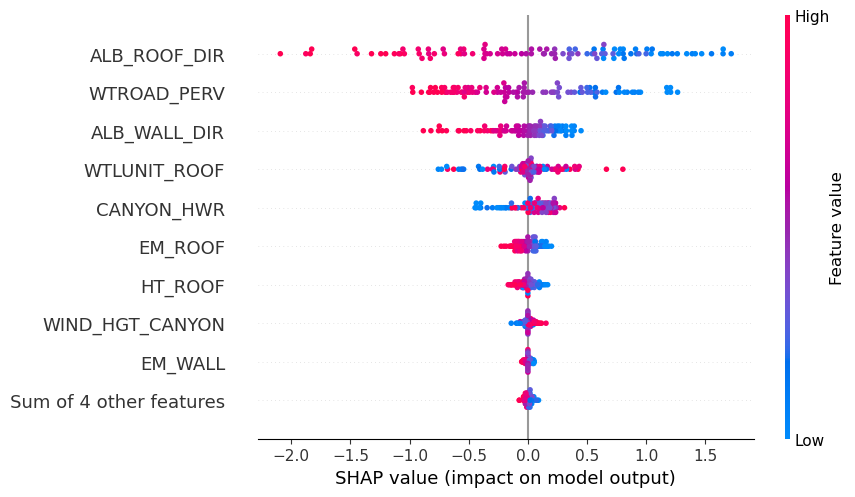

[[-0.83811462 -0.14548044 -0.01688211 ...  0.02013007 -0.00826636
  -0.40599214]
 [ 0.76792273 -0.03235337  0.03563646 ... -0.22963249 -0.40612839
  -0.5386253 ]
 [ 1.051132    0.10915201  0.         ...  0.15225912  0.25650385
  -0.19949824]
 ...
 [-0.56624265 -0.08045422 -0.07318955 ...  0.06465363  0.04613102
   0.44844723]
 [ 1.12278746 -0.08064781 -0.02093588 ... -0.02368319  0.10772912
   0.57044303]
 [ 0.58357882  0.00868277  0.00660005 ...  0.23327     0.02799219
  -0.82265504]]


In [12]:
import shap

model.eval()
X_train_np = X_train.cpu().numpy() if hasattr(X_train, 'cpu') else X_train
X_test_np = X_test.cpu().numpy() if hasattr(X_test, 'cpu') else X_test

def model_predict(x):
    import torch
    x_tensor = torch.tensor(x, dtype=torch.float32)
    with torch.no_grad():
        return model(x_tensor).cpu().numpy()

background = X_train_np[np.random.choice(len(X_train_np), min(100, len(X_train_np)), replace=False)]
X_explain = X_test_np[:100]

explainer = shap.KernelExplainer(model_predict, background) # shap.KernelExplainer 设计为通用模型解释器，适用非树模型（如MLP、SVM、复杂回归等）。计算量很大
shap_values_mlp = explainer.shap_values(X_explain)

# 特征名
feature_names = df1.columns.tolist()  # 如果你的输入df1有列名

# feature_names = [f'Feature_{i}' for i in range(X_train_np.shape[1])]  # 自动数字名
print("shap_values.shape:", shap_values_mlp.shape)
print("X_explain.shape:", X_explain.shape)
print("len(feature_names):", len(feature_names))
print("feature_names:", feature_names)

shap_values_mlp = shap_values_mlp[:, :, 0]

## 反标准化
# SHAP值反标准化（映射到原始输出尺度）
shap_values_mlp_orig = shap_values_mlp * scaler_y.scale_[0]

# 反标准化expected_value（基准输出）
expected_value_scaled = explainer.expected_value
if isinstance(expected_value_scaled, (list, np.ndarray)):
    expected_value_scaled = expected_value_scaled[0]
expected_value_orig = expected_value_scaled * scaler_y.scale_[0] + scaler_y.mean_[0]

# 反标准化模型预测值 f(x)
f_x_scaled = model_predict(X_explain)
f_x_orig = f_x_scaled * scaler_y.scale_[0] + scaler_y.mean_[0]


# 可视化所有特征贡献排序
shap.summary_plot(shap_values_mlp, X_explain, feature_names=feature_names, plot_type='bar')


# 可视化单个样本决策贡献（如果是二维，需flatten）
shap.waterfall_plot(shap.Explanation(
    values=shap_values_mlp_orig[45].flatten(),
    base_values=expected_value_orig,
    data=X_explain[45],
    feature_names=feature_names
))

explanation = shap.Explanation(
    values=shap_values_mlp_orig,  # (n_sample, n_feature)
    base_values=expected_value_orig,
    data=X_explain,
    feature_names=feature_names
)
shap.plots.beeswarm(explanation)

print(shap_values_mlp_orig)

In [13]:
# 加载shap_values
with open('ERP_MLP_shap_values.pkl', 'rb') as f:
    shap_values_MLP = pickle.load(f)

print(shap_values_MLP.shape)

(5600, 13, 1)
